# **Capstone Project: The Battle of Neighborhoods**

**Peer-graded assignment**

**Tobias Zimmer**

# Introduction - Peruvian Cuisine in New York City

Peruvian cuisine is as diverse as its environment – an immense Pacific coast crashing against the mirage of the desert, leading up to some of the tallest peaks in the Andes mountains, and then falling back down into the dense, lush Amazon. Over centuries, the original inhabitants of Peru and their vast civilizations created an array of dishes from this tremendous biodiversity and the cuisine has continued to evolve with the myriad of cultures who have come to call the country home – Spanish, Japanese, Chinese, African, and others.

Consider the famous Peruvian dish *Lomo Saltado*, for example. Lomo saltado is a popular, traditional Peruvian dish, a stir fry that typically combines marinated strips of sirloin (or other beef steak) with onions, tomatoes, french fries, and other ingredients; and is typically served with rice. The dish originated as part of the chifa tradition, the Chinese cuisine of Peru, though its popularity has made it part of the mainstream culture.

With all that it has to offer, it is no wonder that the Peruvian cuisine has successfully established itself in a city like New York. However, it is still a small branch of the culinary world. Therefore, we will have a look at Peruvian restaurants in New York city and explore where the best Pisco and Ceviche can be found.

# Data

**We will use the following data sources:**
1. New York City data (https://cocl.us/new_york_dataset) including boroughs and neighborhoods
2. Foursquare API to obtain venues as well as venue details

## Five questions we want to answer with our analysis:

#### 1. How many Peruvian restaurants exist in New York City?
#### 2. Which borough and which neighborhood of New York City has the highest number of Peruvian restaurants?
#### 3. Which is the best Peruvian restaurant in New York City?
#### 4. Which borough and which neighborhood has the best Peruvian restaurants?
#### 5. Which borough has the highest density of top-rated Peruvian restaurants?

# Methodology:

1. We start with defining the functions to request the required data.
2. We then collect the list of all boroughs and neighborhoods in New York City. 
2. We identify the Peruvian restaurans in each neighborhood using the Foursquare API.
3. We then collect venue information (ratings) for all identified restaurants.
4. We combine geographical data (step 1) with venue data (step 3) to find and map the best areas for Peruvian cuisine.

## **1) Import packages and define functions for API requests**

Import the packages required for this assignmen:

In [141]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup

import geocoder
import os
import folium
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Libraries imported.


Define a function to get the coordinates of a given location using geopy:

In [9]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="peru_nyc")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to download the boroughs and neighborhoods data from the cocl.us dataset:

In [120]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

Define a function to get venue information for given coordinates from FourSquare:

In [46]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100000
    CLIENT_ID = 'K3ZFWRK5KLLY5AAKAIQY14SRNVN5PBJFX0SL2Y2Y0MLOSEKO' # your Foursquare ID
    CLIENT_SECRET = 'ZHMLD2G2SDI3GIDP4CWDPTAGZEEFVMELS03YYBHDZYXLXT2R' # your Foursquare Secret
    VERSION = '20180323' # Foursquare API version
  
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function that requests the details of a venue using the FourSquare API:

In [142]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'K3ZFWRK5KLLY5AAKAIQY14SRNVN5PBJFX0SL2Y2Y0MLOSEKO' # your Foursquare ID
    CLIENT_SECRET = 'ZHMLD2G2SDI3GIDP4CWDPTAGZEEFVMELS03YYBHDZYXLXT2R' # your Foursquare Secret
    VERSION = '20180323' # Foursquare API version
   
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

## **2) Get information about boroughs and neighborhoods in New York City**

Before we look for restaurants, we first collect data about the boroughs and neighborhoods in New York City.

In [13]:
new_york_data=get_new_york_data()

In [14]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
new_york_data.shape

(306, 4)

We can see that there are 306 neighborhoods in New York City.

How are these 306 neighborhoods distributed among the boroughs? We group the data and plot the distribution:

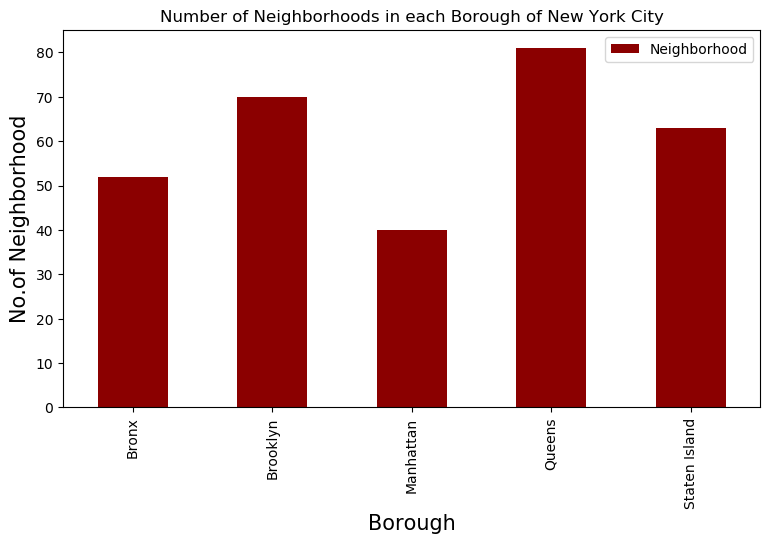

In [92]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods in each Borough of New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar', color='darkred')
#legend
plt.legend()
#displays the plot
plt.show()

We can see in this diagram that Queens has the highest number of neighborhoods.

## **3) Get information about Peruvian Restaurants in New York City**

As we have the list of all neighborhoods, we can now count the Peruvian restaurants in each neighborhood:

In [28]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
peru_rest_ny=pd.DataFrame(columns=column_names)

count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    peruvian_restaurants=venues[venues['Category']=='Peruvian Restaurant']   
    print('Neighborhood',count,'/',len(new_york_data),':','Nr of Peruvian Restaurants in '+Neighborhood+', '+Borough+': '+str(len(peruvian_restaurants)))
    for restaurant_detail in peruvian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        peru_rest_ny = peru_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

Neighborhood 1 / 306 : Nr of Peruvian Restaurants in Wakefield, Bronx: 0
Neighborhood 2 / 306 : Nr of Peruvian Restaurants in Co-op City, Bronx: 0
Neighborhood 3 / 306 : Nr of Peruvian Restaurants in Eastchester, Bronx: 0
Neighborhood 4 / 306 : Nr of Peruvian Restaurants in Fieldston, Bronx: 0
Neighborhood 5 / 306 : Nr of Peruvian Restaurants in Riverdale, Bronx: 0
Neighborhood 6 / 306 : Nr of Peruvian Restaurants in Kingsbridge, Bronx: 0
Neighborhood 7 / 306 : Nr of Peruvian Restaurants in Marble Hill, Manhattan: 0
Neighborhood 8 / 306 : Nr of Peruvian Restaurants in Woodlawn, Bronx: 0
Neighborhood 9 / 306 : Nr of Peruvian Restaurants in Norwood, Bronx: 0
Neighborhood 10 / 306 : Nr of Peruvian Restaurants in Williamsbridge, Bronx: 0
Neighborhood 11 / 306 : Nr of Peruvian Restaurants in Baychester, Bronx: 0
Neighborhood 12 / 306 : Nr of Peruvian Restaurants in Pelham Parkway, Bronx: 0
Neighborhood 13 / 306 : Nr of Peruvian Restaurants in City Island, Bronx: 0
Neighborhood 14 / 306 : Nr

In [29]:
peru_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Mott Haven,4bb28791715eef3b9f5e85bb,Pio Pio
1,Bronx,Port Morris,4bb28791715eef3b9f5e85bb,Pio Pio
2,Brooklyn,Bushwick,4c117b66416620a12136d9e4,Inca Chicken
3,Brooklyn,Gowanus,4db8c0fcfa8c978590c0f6f1,Surfish
4,Brooklyn,Bath Beach,4e3c94bc483b04e17a8b15a6,La granja


*When requesting data via the Foursquare API, sometimes a KeyError occurs. As a result, only a part of the full dataset is obtained. Therefore, the results of a successful download are saved to a CSV file so that they are available even if the API request fails.*

In [144]:
#peru_rest_ny.to_csv('peru_rest_ny.csv', index=False)

In [146]:
peru_rest_ny = pd.read_csv('peru_rest_ny.csv')
peru_rest_ny.head()

,Borough,Neighborhood,ID,Name
46,Queens,Blissville,51ec2df8498ee2a4dc8ee843,Don Pollo II
47,Brooklyn,Vinegar Hill,53d1a481498e1fac7c37f675,Pollo d'Oro
48,Brooklyn,Homecrest,4c12cbd7b7b9c928ef7ca837,Coney Island Taste
49,Manhattan,Hudson Yards,5babb7988194fc002c109112,Chirp
50,Manhattan,Hudson Yards,4b1b1f52f964a52074f823e3,Pio Pio


In [38]:
peru_rest_ny.shape

(51, 4)

#### **Question 1: How many Peruvian restaurants exist in New York City?**

**We can see from the dataframe that there are 51 Peruvian restaurants in New York City.**

How are the restaurants distributed among the boroughs? We again group and plot the dataframe:

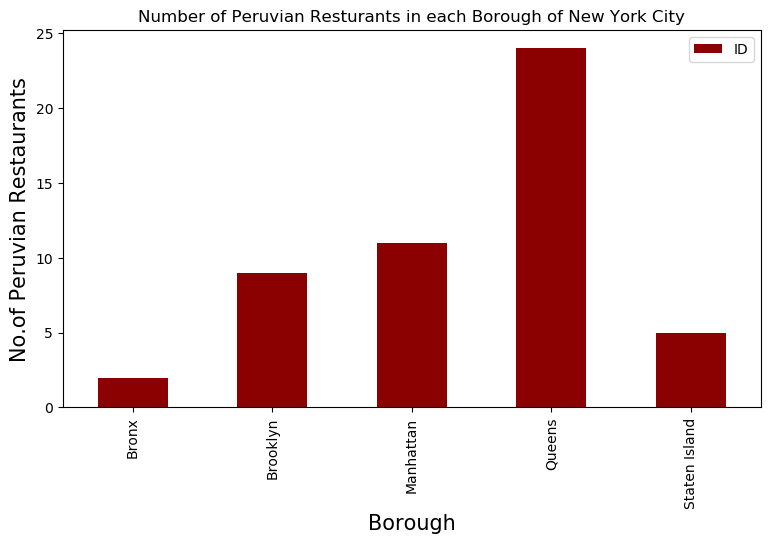

In [39]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Peruvian Resturants in each Borough of New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Peruvian Restaurants', fontsize=15)
#giving a bar plot
peru_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar', color='darkred')
#legend
plt.legend()
#displays the plot
plt.show()

In [149]:
peru_rest_ny.groupby('Borough')['ID'].count()

Borough
Bronx             2
Brooklyn          9
Manhattan        11
Queens           24
Staten Island     5
Name: ID, dtype: int64

#### **Question 2a: Which borough of New York City has the highest number of Peruvian restaurants?**

**We can see that the borough with the highest number of Peruvian restaurants is Queens with 24 restaurants in total.**

However, which are the neighborhoods with the highest number of Peruvian restaurants?

We will repeat the analysis for neighborhoods instead of boroughs:

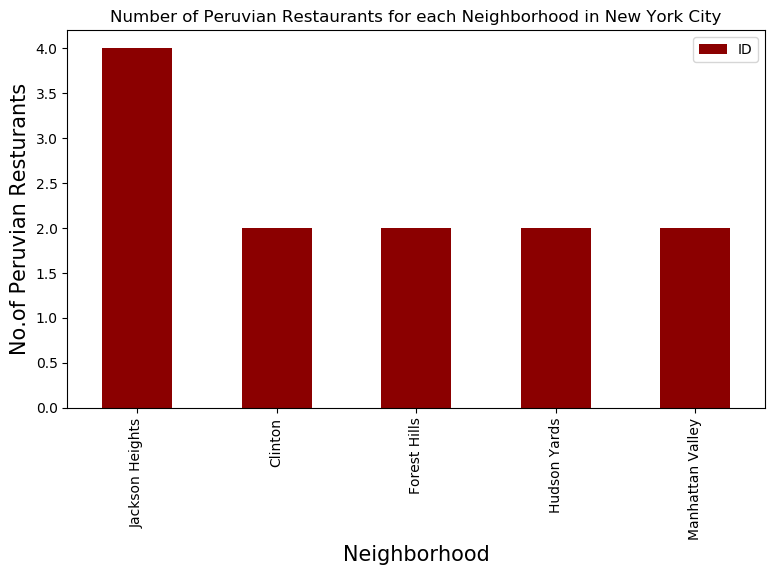

In [40]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Peruvian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Peruvian Resturants', fontsize=15)
#giving a bar plot
peru_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar', color='darkred')
#legend
plt.legend()
#displays the plot
plt.show()

#### **Question 2b: Which neighborhood of New York City has the highest number of Peruvian restaurants?**

**We can see that there is one neighborhood, Jackson Heights, which has four Peruvian restaurants.**

**The four restaurants in Jackson Heights are shown below:**

In [42]:
peru_rest_ny[peru_rest_ny['Neighborhood']=='Jackson Heights']

,Borough,Neighborhood,ID,Name
16,Queens,Jackson Heights,4b9ece55f964a520590337e3,Urubamba
17,Queens,Jackson Heights,4b8344cff964a520f0ff30e3,Pio Pio
18,Queens,Jackson Heights,4f9771e4e5e8dedda9c72330,Pio Pio to Go
19,Queens,Jackson Heights,557870be498e72ac68e380c0,Juanita’s Café


## **4) Analyze the ratings of all restaurants**

We will now analyze the ratings of all 51 Peruvian restaurants. To do so, we have to download the venue details via the FourSquare API:

In [85]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
peru_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in peru_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('Restaurant',count,'/',len(peru_rest_ny),'processed')
    peru_rest_stats_ny = peru_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID     Name  Likes  Rating  Tips
0  4bb28791715eef3b9f5e85bb  Pio Pio     67     8.8    23
Restaurant 1 / 51 processed
                         ID     Name  Likes  Rating  Tips
0  4bb28791715eef3b9f5e85bb  Pio Pio     67     8.8    23
Restaurant 2 / 51 processed
                         ID          Name  Likes  Rating  Tips
0  4c117b66416620a12136d9e4  Inca Chicken     34     8.5    15
Restaurant 3 / 51 processed
                         ID     Name  Likes  Rating  Tips
0  4db8c0fcfa8c978590c0f6f1  Surfish    134     8.2    58
Restaurant 4 / 51 processed
                         ID       Name  Likes  Rating  Tips
0  4e3c94bc483b04e17a8b15a6  La granja      6     6.9     6
Restaurant 5 / 51 processed
                         ID         Name  Likes  Rating  Tips
0  53d1a481498e1fac7c37f675  Pollo d'Oro     43     8.3    16
Restaurant 6 / 51 processed
                         ID                      Name  Likes  Rating  Tips
0  53cb315f498e5a7d7afbf60a  Lima Peruv

In [140]:
peru_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Mott Haven,4bb28791715eef3b9f5e85bb,Pio Pio,67.0,8.8,23.0
1,Bronx,Port Morris,4bb28791715eef3b9f5e85bb,Pio Pio,67.0,8.8,23.0
2,Brooklyn,Bushwick,4c117b66416620a12136d9e4,Inca Chicken,34.0,8.5,15.0
3,Brooklyn,Gowanus,4db8c0fcfa8c978590c0f6f1,Surfish,134.0,8.2,58.0
4,Brooklyn,Bath Beach,4e3c94bc483b04e17a8b15a6,La granja,6.0,6.9,6.0


*When requesting data via the Foursquare API, sometimes a KeyError occurs. As a result, only a part of the full dataset is obtained. Therefore, the results of a successful download are saved to a CSV file so that they are available even if the API request fails.*

In [87]:
#peru_rest_stats_ny.to_csv('peru_rest_stats_ny.csv', index=False)

In [152]:
peru_rest_stats_ny = pd.read_csv('peru_rest_stats_ny.csv')
peru_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Mott Haven,4bb28791715eef3b9f5e85bb,Pio Pio,67,8.8,23
1,Bronx,Port Morris,4bb28791715eef3b9f5e85bb,Pio Pio,67,8.8,23
2,Brooklyn,Bushwick,4c117b66416620a12136d9e4,Inca Chicken,34,8.5,15
3,Brooklyn,Gowanus,4db8c0fcfa8c978590c0f6f1,Surfish,134,8.2,58
4,Brooklyn,Bath Beach,4e3c94bc483b04e17a8b15a6,La granja,6,6.9,6


Convert data saved as strings to float:

In [95]:
peru_rest_stats_ny['Likes']=peru_rest_stats_ny['Likes'].astype('float64')
peru_rest_stats_ny['Tips']=peru_rest_stats_ny['Tips'].astype('float64')
#peru_rest_stats_ny.info()

We can now look for the best Peruvian restaurant. We will consider two criteria: Ratings and Likes.

First, we determine the restaurant with the best ratings:

In [98]:
peru_rest_stats_ny.iloc[peru_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              5b95359481a0ea002cdce0ce
Name                           Llama-San
Likes                                 80
Rating                                 9
Tips                                  14
Name: 12, dtype: object

Second, we determine the restaurant with the highest number of likes:

In [97]:
peru_rest_stats_ny.iloc[peru_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Clinton
ID              4b1b1f52f964a52074f823e3
Name                             Pio Pio
Likes                               1122
Rating                               8.9
Tips                                 329
Name: 10, dtype: object

#### **Question 3: Which is the best Peruvian restaurant in New York City?**

**The restaurant with the highest rating is Llama-San in Greenwich Village, Manhattan. The restaurant with the highest number of likes is Pio Pio which is also located in Manhattan (Clinton).**

## **5) Identify and plot the best areas for Peruvian cuisine in New York City**

We will now combine the results from step 2) and step 3) to find the best boroughs and neighborhoods with respect to Peruvian cuisine.

In [100]:
ny_neighborhood_stats=peru_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [101]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
39,West Village,9.0
17,Greenwich Village,9.0
20,Hudson Yards,8.8
27,Mott Haven,8.8
5,Clinton,8.8
31,Port Morris,8.8
23,Little Neck,8.5
21,Hunters Point,8.5
11,Elmhurst,8.5
8,Douglaston,8.5


#### **Question 4a: Which neighborhood has the best Peruvian restaurants?**

**We can see that West Village and Greenwich Village are excellent neighborhoods with regards to Peruvian cuisine as both have an average rating of 9.0.**

In the same way, we will now determine the average rating of Peruvian restaurants in each borough.

In [122]:
ny_borough_stats = peru_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns = ['Borough','Average Rating']

In [139]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,8.800000
2,Manhattan,8.545455
3,Queens,7.825000
1,Brooklyn,7.822222
4,Staten Island,7.540000


#### **Question 4b: Which borough has the best Peruvian restaurants?**

**We can see that although Queens has the most Peruvian restaurants and also the best ones, the Bronx has the highest average rating.**

Now we will visualize this result:

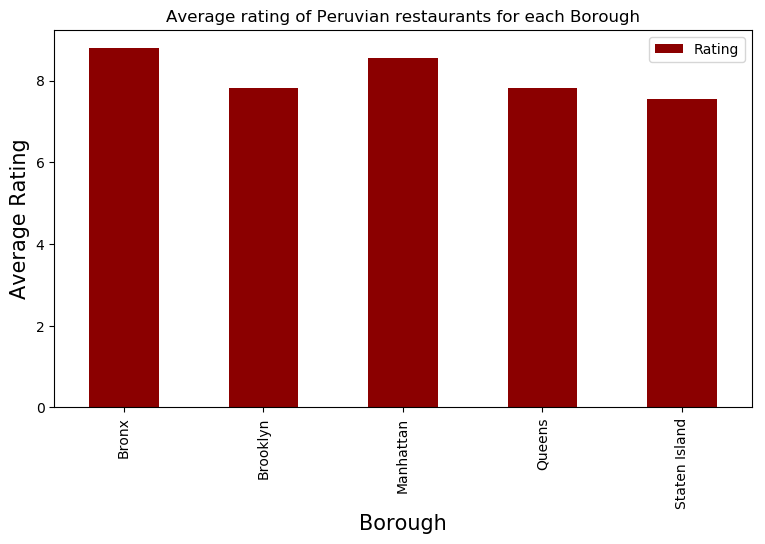

In [125]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Peruvian restaurants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
peru_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar',color='darkred')
#legend
plt.legend()
#displays the plot
plt.show()

As we are looking for very good restaurants, we will focus now on neighborhoods with an average rating of 8.5 or higher.

In [130]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

In [131]:
ny_neighborhood_stats

,Borough_x,Neighborhood,Latitude_x,Longitude_x,Average Rating,Label,Borough_y,Latitude_y,Longitude_y
0,Brooklyn,Bushwick,40.698116,-73.925258,8.5,"Bushwick, Brooklyn(8.5)",Brooklyn,40.698116,-73.925258
1,Manhattan,Clinton,40.759101,-73.996119,8.8,"Clinton, Manhattan(8.8)",Manhattan,40.759101,-73.996119
2,Queens,Douglaston,40.766846,-73.742498,8.5,"Douglaston, Queens(8.5)",Queens,40.766846,-73.742498
3,Queens,Elmhurst,40.744049,-73.881656,8.5,"Elmhurst, Queens(8.5)",Queens,40.744049,-73.881656
4,Manhattan,Greenwich Village,40.726933,-73.999914,9.0,"Greenwich Village, Manhattan(9.0)",Manhattan,40.726933,-73.999914
5,Manhattan,Hudson Yards,40.756658,-74.000111,8.8,"Hudson Yards, Manhattan(8.8)",Manhattan,40.756658,-74.000111
6,Queens,Hunters Point,40.743414,-73.953868,8.5,"Hunters Point, Queens(8.5)",Queens,40.743414,-73.953868
7,Queens,Little Neck,40.770826,-73.738898,8.5,"Little Neck, Queens(8.5)",Queens,40.770826,-73.738898
8,Bronx,Mott Haven,40.806239,-73.916100,8.8,"Mott Haven, Bronx(8.8)",Bronx,40.806239,-73.916100
9,Bronx,Port Morris,40.801664,-73.913221,8.8,"Port Morris, Bronx(8.8)",Bronx,40.801664,-73.913221


To plot these neighborhoods in a map, we add the longitude and latitude from the New York data set above.

In [132]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [133]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [134]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bushwick,40.698116,-73.925258,8.5
1,Manhattan,Clinton,40.759101,-73.996119,8.8
2,Queens,Douglaston,40.766846,-73.742498,8.5
3,Queens,Elmhurst,40.744049,-73.881656,8.5
4,Manhattan,Greenwich Village,40.726933,-73.999914,9.0
5,Manhattan,Hudson Yards,40.756658,-74.000111,8.8
6,Queens,Hunters Point,40.743414,-73.953868,8.5
7,Queens,Little Neck,40.770826,-73.738898,8.5
8,Bronx,Mott Haven,40.806239,-73.916100,8.8
9,Bronx,Port Morris,40.801664,-73.913221,8.8


Finally, we plot the identified neighborhoods using Folium:

In [136]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [138]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'    

for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

#### **Question 5: Which borough has the highest density of top-rated Peruvian restaurants?**

**We can see in the map, that four highly rated restaurants can be found in Manhattan.**

# Summary:

### We can now summarize the answers we have found to our questions:

**Question 1: How many Peruvian restaurants exist in New York City?**

In June 2020, there are 51 Peruvian restaurants in New York City.

**Question 2: Which borough and which neighborhood of New York City has the highest number of Peruvian restaurants?**

The borough with the highest number of Peruvian restaurants is Queens with 24 restaurants in total. The neighborhood with the highest number of Peruvian restaurants is Jackson Heights which is located in Queens.

**Question 3: Which is the best Peruvian restaurant in New York City?**

The restaurant with the highest rating is Llama-San in Greenwich Village, Manhattan. The restaurant with the highest number of likes is Pio Pio which is also located in Manhattan (Clinton).

**Question 4: Which borough and which neighborhood has the best Peruvian restaurants?**

The neighborhoods with the highest rating are West Village and Greenwich Village. Both are in Manhattan and have an average rating of 9. But although Queens has the most Peruvian restaurants and although the best two neighborhoods are in Manhattan, the Bronx has the highest average rating.

**Question 5: Which borough has the highest density of top-rated Peruvian restaurants?**

Four highly rated restaurants are located relatively close to another in Manhattan so that this borough has the highest density of top Peruvian restaurants.
